In [1]:
# generate a phase diagram for a toy system using polyphase parallel compute tool
import polyphase as phase
import numpy as np

M = [5,5,1]
chi = [1, 0.5, 0.5]
f = lambda x : phase.flory_huggins(x, M, chi)
engine = phase.PHASE(f,200,3)
engine.compute(use_parallel=False, verbose=True, lift_label=True)

3-dimensional grid generated at 0.22s
Energy computed at 1.98s
Making energy manifold a paraboloid with 2x padding of 0.11 maximum energy
Energy is corrected at 3.30s
Convexhull is computed at 3.34s
Using 1.01E-01 as a threshold for Laplacian of a simplex
Simplices are refined at 3.63s
Total of 9599 simplices in the convex hull
Simplices are labelled at 6.57s
Labels are lifted at 14.35s
Total 0/9599 coplanar simplices
Computation took 14.56s


In [2]:
# to make use of the parallel computation pipeline
engine.compute(use_parallel=True, verbose=True, lift_label=True)

2020-11-11 14:12:39,778	INFO services.py:1166 -- View the Ray dashboard at http://127.0.0.1:8265


3-dimensional grid generated at 0.36s
Energy computed at 3.01s
Making energy manifold a paraboloid with 2x padding of 0.11 maximum energy
Energy is corrected at 14.82s
Convexhull is computed at 14.87s
Using 1.01E-01 as a threshold for Laplacian of a simplex
Total of 9599 simplices in the convex hull
Simplices are refined at 16.91s
Simplices are labelled at 19.09s
Labels are lifted at 21.89s
Total 0/9599 coplanar simplices
Computation took 22.25s


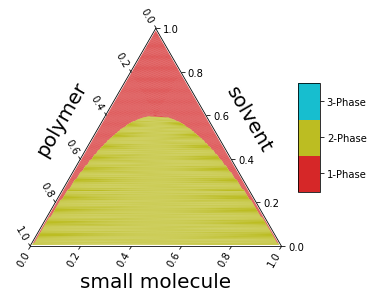

In [3]:
import matplotlib.pyplot as plt

phase.plot_mpltern(engine.grid, engine.simplices, engine.num_comps)
plt.show()

In [4]:
# We can also compute phase splits given a composition using the following
boundary_points = np.asarray([engine.is_boundary_point(x) for x in engine.grid.T])
no_boundary_grid = np.where(~boundary_points)[0]
point = engine.grid[:,np.random.choice(no_boundary_grid)]
print(point)
engine(point)

[0.21608041 0.25125629 0.53266332]


(array([ 0.43719485,  0.56546826, -0.00266312]),
 array([[0.38693468, 0.09045227, 0.37688443],
        [0.08542714, 0.37688443, 0.09045227],
        [0.52261307, 0.5276382 , 0.5276382 ]]),
 2)